In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint 
from statsmodels import api
import statsmodels



### Measures of Statistical Dependency
- Correlation
- Covariance
- Copulas
- Cointegration

## Market Instrument Screener for Pairs Trading Strategy

Text(0.5, 1.0, 'Assets Correlation Matrix')

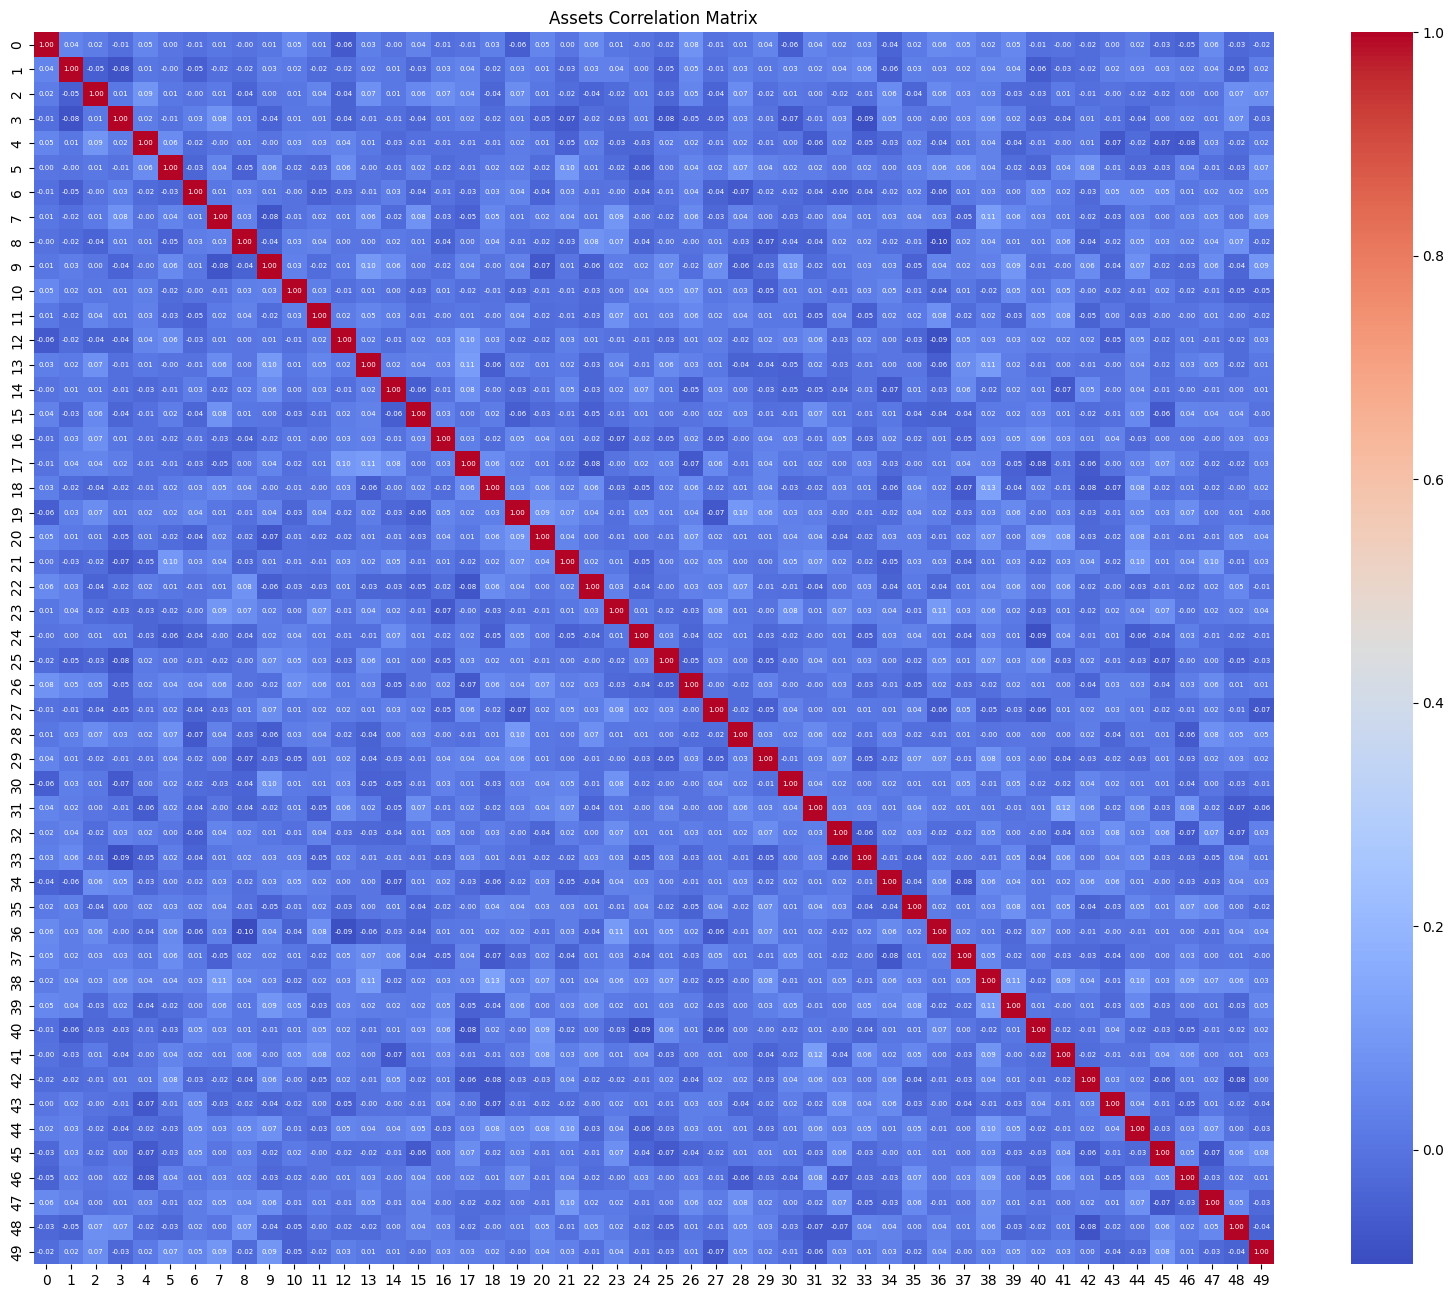

In [22]:
# Pearson correlation to get the basic idea about the relationship
#

#  1. Create a Matplotlib Figure & Axes, set size
fig, ax = plt.subplots(figsize=(20,16))
sns.heatmap(
    df.pct_change().corr(method = 'pearson'),
    cmap='coolwarm',
    annot=True,
    annot_kws={"fontsize": 5},
    fmt=".2f"
)
ax.set_title('Assets Correlation Matrix')


In [ ]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap
scores, pvalues, pairs = find_cointegrated_pairs(prices_df)
import seaborn

plt.figure(figsize=(12, 12)) 

seaborn.heatmap(
    pvalues,
    xticklabels=prices_df.columns,
    yticklabels=prices_df.columns,
    cmap='RdYlGn_r',
    mask = (pvalues >= 0.05))
print(pairs)
plt.show()

NameError: name 'find_cointegrated_pairs' is not defined

In [ ]:
def top_cointegration_pairs (instrument_df):
    '''
    Return: 
    '''
    P_VALUE_CUTOFF = 0.05
    

In [14]:
arr = np.loadtxt("../prices.txt")
df = pd.DataFrame(data = arr)
df.head()


def find_top_cointegrated_pairs(stock_prices_df):
    P_VALUE_CUTOFF = 0.05
    cointegration_pairs = {}

    for i in range(stock_prices_df.shape[1]):
        for j in range(i+1, stock_prices_df.shape[1]):
            # run the test and unpack only the p-value
            _, pvalue, _ = coint(stock_prices_df[i], stock_prices_df[j])
            cointegration_pairs[(i,j)] = float(pvalue)

    # now build a Series of floats, sort it, and filter
    series = pd.Series(cointegration_pairs).sort_values()
    series = series[ series < P_VALUE_CUTOFF ]

    # greedily pick non-overlapping top pairs
    all_pairs = list(series.index)
    top_pairs = []
    for pair in series.index:
        if pair in all_pairs:
            top_pairs.append(pair)
            # remove any pairs sharing either leg
            all_pairs = [p for p in all_pairs
                         if (p[0] not in pair and p[1] not in pair)]
    return top_pairs

find_top_cointegrated_pairs(df)

[(48, 49),
 (8, 34),
 (33, 35),
 (18, 29),
 (11, 23),
 (25, 36),
 (2, 6),
 (26, 45),
 (37, 41),
 (7, 13),
 (20, 22),
 (0, 40)]

In [45]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import coint

def find_top_cointegrated_pairs(
    prices: pd.DataFrame,
    p_value_cutoff: float = 0.05,
    top_n: int = None
) -> list[tuple[int,int]]:
    """
    Identify top cointegrated pairs in a universe.

    Parameters
    ----------
    prices : DataFrame, shape (T, N)
        Daily prices, columns = instruments.
    p_value_cutoff : float
        Only consider pairs with p-value < cutoff.
    top_n : int or None
        Maximum number of disjoint pairs to return. If None, returns all.

    Returns
    -------
    top_pairs : list of (i, j)
        List of selected index‐tuples (i<j).
    """
    n = prices.shape[1]
    pvals = {}
    # 1) compute p-values for every pair
    for i in range(n):
        for j in range(i+1, n):
            # Engle-Granger cointegration test
            _, pval, _ = coint(prices.iloc[:, i], prices.iloc[:, j])
            if pval < p_value_cutoff:
                pvals[(i, j)] = float(pval)

    # 2) sort by ascending p-value
    sorted_pairs = sorted(pvals.items(), key=lambda kv: kv[1])
    candidates = [pair for pair, _ in sorted_pairs]

    # 3) greedily pick non-overlapping pairs
    top_pairs = []
    used = set()
    for (i, j) in candidates:
        if (i not in used) and (j not in used):
            top_pairs.append((i, j))
            used.update([i, j])
            if top_n is not None and len(top_pairs) >= top_n:
                break

    return top_pairs


In [46]:
import numpy as np, pandas as pd

# Load your 50×T price array into a DataFrame
arr = np.loadtxt("../prices.txt")
prices = pd.DataFrame(arr.T, columns=[f"inst{i}" for i in range(arr.shape[0])])

# Find the top 5 cointegrated pairs (p<0.05)
top5 = find_top_cointegrated_pairs(prices, p_value_cutoff=0.05, top_n=10)
print("Top 5 cointegrated pairs:", top5)


Top 5 cointegrated pairs: [(146, 148), (67, 79), (145, 149), (550, 554), (514, 534), (548, 611), (133, 138), (525, 536), (447, 448), (337, 362)]


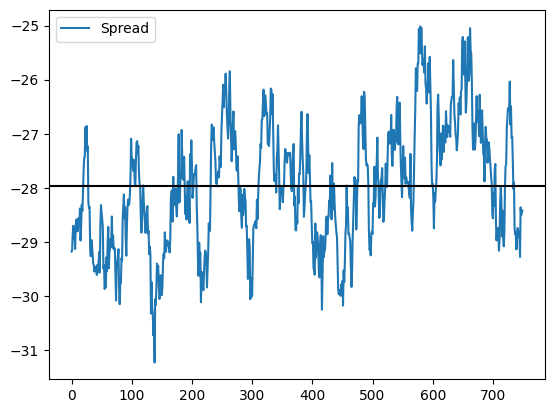

In [27]:
S1 = df[48]  
S2 = df[49]  
score, pvalue, _ = coint(S1, S2, maxlag=1)
pvalue

S1 = statsmodels.api.add_constant(S1)
results = statsmodels.api.OLS(S2, S1).fit()
S1 = S1[48]
b = results.params[48]

spread = S2 - b * S1
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);

In [29]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

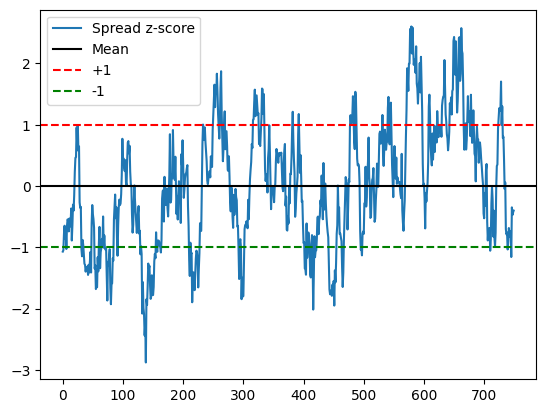

In [28]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

In [31]:
# Create a DataFrmae with the signal and position size in the pair
trades = pd.concat([zscore(spread), S2 - b * S1], axis=1)
trades.columns = ["signal", "position"]

# Add a long and short position at the z-score levels
trades["side"] = 0.0
trades.loc[trades.signal <= -1, "side"] = 1
trades.loc[trades.signal >= 1, "side"] = -1

0.8965152149564407


<Axes: >

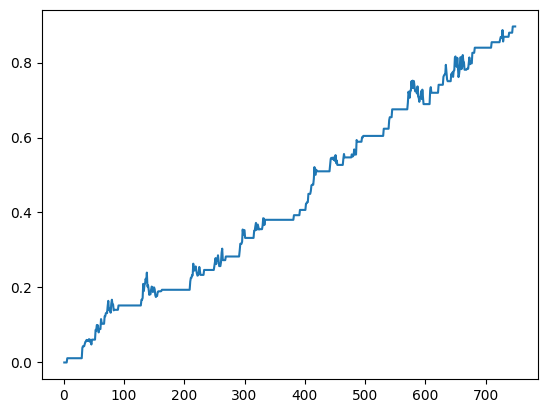

In [35]:
returns = trades.position.pct_change() * trades.side
cum_returns = returns.cumsum()
final_ret = cum_returns.iloc[-1]
print(final_ret)
returns.cumsum().plot()


In [ ]:
#eval.py

import numpy as np
import pandas as pd
from teamName import getMyPosition as getPosition

nInst = 0
nt = 0
commRate = 0.0005
dlrPosLimit = 10000

def loadPrices(fn):
    global nt, nInst
    df=pd.read_csv(fn, sep='\s+', header=None, index_col=None)
    (nt,nInst) = df.shape
    return (df.values).T

pricesFile="./priceSlice_test.txt"
prcAll = loadPrices(pricesFile)
print ("Loaded %d instruments for %d days" % (nInst, nt))

def calcPL(prcHist, numTestDays):
    cash = 0
    curPos = np.zeros(nInst)
    totDVolume = 0
    totDVolumeSignal = 0
    totDVolumeRandom = 0
    value = 0
    todayPLL = []
    (_,nt) = prcHist.shape
    startDay = nt + 1 - numTestDays
    for t in range(startDay, nt+1):
        prcHistSoFar = prcHist[:,:t]
        curPrices = prcHistSoFar[:,-1]
        if (t < nt):
            # Trading, do not do it on the very last day of the test
            newPosOrig = getPosition(prcHistSoFar)
            posLimits = np.array([int(x) for x in dlrPosLimit / curPrices])
            newPos = np.clip(newPosOrig, -posLimits, posLimits)
            deltaPos = newPos - curPos
            dvolumes = curPrices * np.abs(deltaPos)
            dvolume = np.sum(dvolumes)
            totDVolume += dvolume
            comm = dvolume * commRate
            cash -= curPrices.dot(deltaPos) + comm
        else:
            newPos = np.array(curPos)
        curPos = np.array(newPos)
        posValue = curPos.dot(curPrices)
        todayPL = cash + posValue - value
        value = cash + posValue
        ret = 0.0
        if (totDVolume > 0):
            ret = value / totDVolume
        if (t > startDay):
            print ("Day %d value: %.2lf todayPL: $%.2lf $-traded: %.0lf return: %.5lf" % (t,value, todayPL, totDVolume, ret))
            todayPLL.append(todayPL)
    pll = np.array(todayPLL)
    (plmu,plstd) = (np.mean(pll), np.std(pll))
    annSharpe = 0.0
    if (plstd > 0):
        annSharpe = np.sqrt(249) * plmu / plstd
    return (plmu, ret, plstd, annSharpe, totDVolume)



(meanpl, ret, plstd, sharpe, dvol) = calcPL(prcAll,200)
score = meanpl - 0.1*plstd
print ("=====")
print ("mean(PL): %.1lf" % meanpl)
print ("return: %.5lf" % ret)
print ("StdDev(PL): %.2lf" % plstd)
print ("annSharpe(PL): %.2lf " % sharpe)
print ("totDvolume: %.0lf " % dvol)
print ("Score: %.2lf" % score)



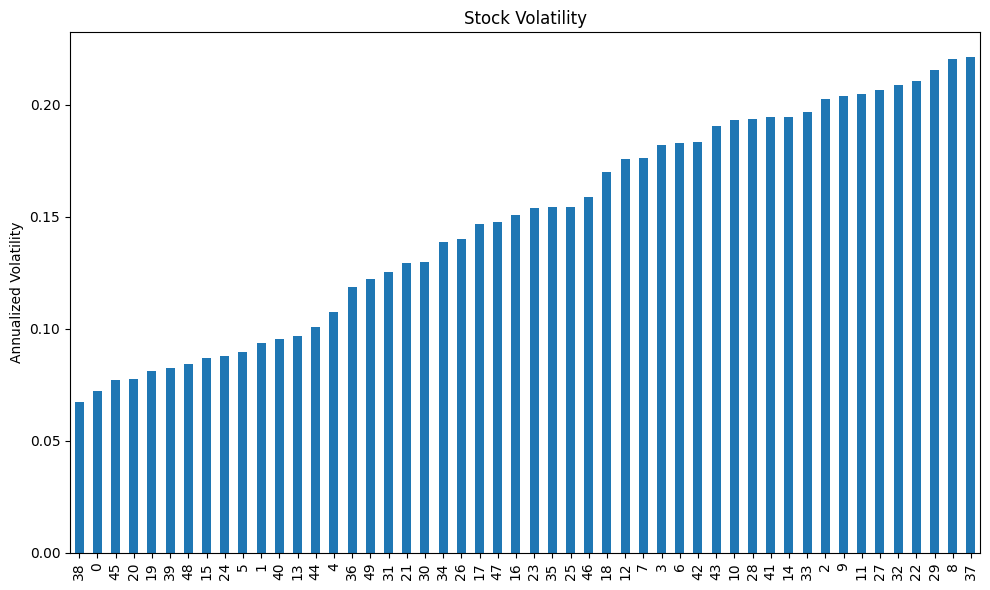

In [37]:
returns = df.pct_change()
daily_vol = returns.std()
annual_vol = daily_vol * np.sqrt(252)

# Plot bar chart of annualized volatility
fig, ax = plt.subplots(figsize=(10, 6))
annual_vol.sort_values().plot.bar(ax=ax)
ax.set_ylabel('Annualized Volatility')
ax.set_title('Stock Volatility')
plt.tight_layout()
plt.show()


In [38]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import warnings

# Re-use Clayton log‐likelihood from before
def clayton_loglik(theta, u, v):
    if theta <= 0:
        return np.inf
    term = (u**(-theta) + v**(-theta) - 1)
    if np.any(term <= 0):
        return np.inf
    ll = np.log(theta + 1) - (theta + 1)*(np.log(u) + np.log(v)) - (2 + 1/theta)*np.log(term)
    return -np.sum(ll)

def fit_clayton(u, v):
    # suppress any convergence warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", ConvergenceWarning)
        res = minimize(lambda t: clayton_loglik(t, u, v),
                       x0=1.0,
                       bounds=[(1e-3, 50)],
                       method='L-BFGS-B')
    return res.x[0] if res.success else np.nan

def screen_copula_pairs(prices: pd.DataFrame, window: int=None) -> pd.DataFrame:
    """
    Compute Clayton θ for all i<j pairs.
    Returns DataFrame with columns [i, j, theta], sorted descending by theta.
    If window is set, use only the last `window` rows of `prices`.
    """
    df = prices if window is None else prices.iloc[-window:]
    ranks = df.rank(axis=0, pct=True).values  # array shape (T, N)
    n = df.shape[1]
    results = []
    for i in range(n):
        for j in range(i+1, n):
            u = ranks[:, i]
            v = ranks[:, j]
            theta = fit_clayton(u, v)
            results.append((i, j, theta))
    screener = pd.DataFrame(results, columns=['i','j','theta'])
    return screener.sort_values('theta', ascending=False).reset_index(drop=True)


In [39]:
import numpy as np, pandas as pd

# Load your data (days × instruments)
arr = np.loadtxt("../prices.txt")
prices = pd.DataFrame(arr.T, columns=[f"inst{k}" for k in range(arr.shape[0])])

# Screen on full history
df_screen = screen_copula_pairs(prices)
print(df_screen.head(10))

# Or only last 240 days
df_screen240 = screen_copula_pairs(prices, window=240)
print(df_screen240.head(10))


     i    j  theta
0    0    1   50.0
1  364  365   50.0
2  431  434   50.0
3  431  432   50.0
4  428  429   50.0
5  427  428   50.0
6  426  428   50.0
7  425  428   50.0
8  425  427   50.0
9  425  426   50.0
     i    j  theta
0    0    1   50.0
1  364  365   50.0
2  431  434   50.0
3  431  432   50.0
4  428  429   50.0
5  427  428   50.0
6  426  428   50.0
7  425  428   50.0
8  425  427   50.0
9  425  426   50.0


Sample daily P&L:
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
dtype: float64
Total P&L over test period: $3.73
Mean daily P&L         : $0.07
StdDev daily P&L       : $0.33


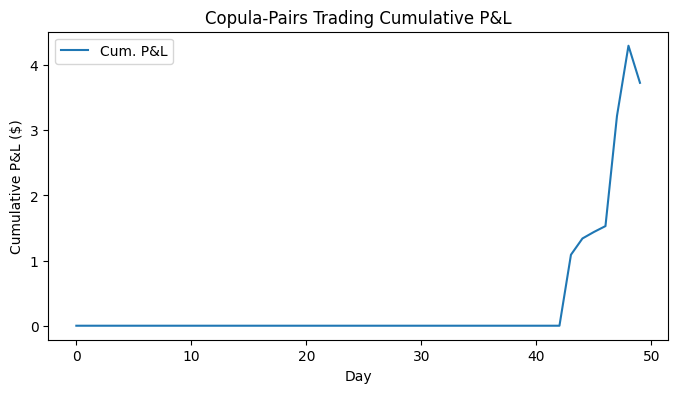

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



def copula_pair_signals(prices: pd.DataFrame, pairs, entry_z=2, exit_z=0, lookback=20):
    n = prices.shape[1]
    signals = pd.DataFrame(0, index=prices.index, columns=prices.columns)
    for (i, j) in pairs:
        xi = prices.iloc[:, i]
        xj = prices.iloc[:, j]
        betas = pd.Series(np.nan, index=prices.index)
        for t in range(lookback, len(prices)):
            y = xj.iloc[t-lookback:t]
            X = xi.iloc[t-lookback:t]
            betas.iloc[t] = np.polyfit(X, y, 1)[0]
        spread = xj - betas * xi
        m = spread.rolling(lookback).mean()
        s = spread.rolling(lookback).std()
        z = (spread - m) / s
        for t in range(lookback, len(prices)):
            if z.iloc[t] >= entry_z:
                signals.iat[t, j] = -1
                signals.iat[t, i] = +1
            elif z.iloc[t] <= -entry_z:
                signals.iat[t, j] = +1
                signals.iat[t, i] = -1
            else:
                signals.iat[t, j] = signals.iat[t-1, j]
                signals.iat[t, i] = signals.iat[t-1, i]
    return signals



# ———————————
# 1) Load your price data
# ———————————
# adjust the path if your notebook lives in a subfolder
arr    = np.loadtxt("../prices.txt")
prices = pd.DataFrame(arr.T, 
                      index=range(arr.shape[1]), 
                      columns=[f"inst{i}" for i in range(arr.shape[0])])

# ———————————
# 2) Screen for top copula pairs
# ———————————
# (reuse your screen_copula_pairs as defined earlier)
screener = screen_copula_pairs(prices, window=240)
top_pairs = list(screener.iloc[:5][['i','j']].itertuples(index=False, name=None))

# ———————————
# 3) Build trading signals
# ———————————
# (reuse your copula_pair_signals function)
signals = copula_pair_signals(prices, top_pairs, lookback=20)

# ———————————
# 4) Compute daily P&L
# ———————————
# assume 1 share per signal unit
price_diff = prices.diff().fillna(0)
# shift signals so that today’s positions apply to tomorrow’s price change
daily_pnl  = (signals.shift(1).fillna(0) * price_diff).sum(axis=1)

# ———————————
# 5) Inspect & plot
# ———————————
print("Sample daily P&L:")
print(daily_pnl.head())

print(f"Total P&L over test period: ${daily_pnl.sum():.2f}")
print(f"Mean daily P&L         : ${daily_pnl.mean():.2f}")
print(f"StdDev daily P&L       : ${daily_pnl.std():.2f}")

# Cumulative P&L curve
cum_pnl = daily_pnl.cumsum()
plt.figure(figsize=(8,4))
plt.plot(cum_pnl, label="Cum. P&L")
plt.title("Copula-Pairs Trading Cumulative P&L")
plt.xlabel("Day")
plt.ylabel("Cumulative P&L ($)")
plt.legend()
plt.show()


In [43]:
import numpy as np
import pandas as pd
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# 1) Load your (750 × 50) price matrix
prices = np.loadtxt("../prices.txt")   # shape should be (750, 50)

# 2) Optionally wrap in a DataFrame for nicer labels
n_days, n_stocks = prices.shape
stock_names = [f"Stock_{i}" for i in range(n_stocks)]
prices_df = pd.DataFrame(prices, columns=stock_names)

# 3) Run pairwise Johansen tests and collect trace statistics
results = []
for i in range(n_stocks):
    for j in range(i + 1, n_stocks):
        pair_data = prices_df.iloc[:, [i, j]].values
        # det_order=0 => no intercept in cointegration relation
        # k_ar_diff=1 => 1 lag in the underlying VAR
        joh = coint_johansen(pair_data, det_order=0, k_ar_diff=1)
        trace_stat = joh.lr1[0]  # test H0: rank=0 vs H1: rank>=1
        results.append({
            "pair": f"{stock_names[i]} & {stock_names[j]}",
            "trace_stat": trace_stat
        })

# 4) Rank and display the top 10 most‐cointegrated pairs
res_df = pd.DataFrame(results)
res_df = res_df.sort_values("trace_stat", ascending=False).reset_index(drop=True)
print(res_df.head(10))


                  pair  trace_stat
0  Stock_25 & Stock_48   38.079420
1  Stock_33 & Stock_48   36.776554
2  Stock_33 & Stock_49   36.597552
3  Stock_15 & Stock_37   32.889588
4  Stock_33 & Stock_37   31.684352
5  Stock_48 & Stock_49   30.955969
6   Stock_8 & Stock_37   30.883046
7  Stock_25 & Stock_49   30.828460
8  Stock_25 & Stock_37   29.319678
9  Stock_25 & Stock_33   29.265958
